# 연구 1단계 (GPU 버전): 2차 함수 환경에서 노이즈와 GMM 복잡도 관계 분석

## ⚠️ 실행 전 필수 확인 사항 ⚠️
본 노트북은 GPU 가속을 위해 NVIDIA RAPIDS `cuML` 라이브러리를 사용합니다. 실행을 위해서는 NVIDIA GPU 및 관련 `conda` 환경 설정이 필요합니다.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class PyTorchGMM(nn.Module):
    def __init__(self, n_components, n_features, device='cuda'):
        super(PyTorchGMM, self).__init__()
        self.n_components = n_components
        self.n_features = n_features
        self.device = device

        # 파라미터 초기화
        self.pi = nn.Parameter(torch.ones(n_components, device=self.device) / n_components, requires_grad=True)
        self.mu = nn.Parameter(torch.randn(n_components, n_features, device=self.device), requires_grad=True)
        # 공분산 행렬은 양의 정부호 행렬이어야 하므로, Cholesky 분해를 이용합니다.
        # L * L.T 형태로 공분산 행렬을 만듭니다. L은 하삼각행렬입니다.
        self.log_diag_L = nn.Parameter(torch.randn(n_components, n_features, device=self.device), requires_grad=True)
        self.off_diag_L = nn.Parameter(torch.randn(n_components, n_features * (n_features - 1) // 2, device=self.device), requires_grad=True)


    def _get_cov(self):
        """
        Cholesky 분해의 파라미터로부터 공분산 행렬을 구성합니다.
        """
        covs = torch.zeros(self.n_components, self.n_features, self.n_features, device=self.device)
        for k in range(self.n_components):
            L = torch.zeros(self.n_features, self.n_features, device=self.device)
            # 대각 성분
            # L.diag(torch.exp(self.log_diag_L[k]))
            L[range(self.n_features), range(self.n_features)] = torch.exp(self.log_diag_L[k])
            # 비대각 성분
            tril_indices = torch.tril_indices(row=self.n_features, col=self.n_features, offset=-1)
            L[tril_indices[0], tril_indices[1]] = self.off_diag_L[k]
            covs[k] = torch.matmul(L, L.T) + torch.eye(self.n_features, device=self.device) * 1e-6 # 안정성을 위해 작은 값 추가
        return covs

    def forward(self, x):
        """
        주어진 데이터 x에 대한 GMM의 음의 로그 우도(negative log-likelihood)를 계산합니다.
        """
        covs = self._get_cov()
        
        weighted_log_prob = torch.zeros(x.size(0), self.n_components, device=self.device)
        for k in range(self.n_components):
            dist = torch.distributions.MultivariateNormal(self.mu[k], covs[k])
            weighted_log_prob[:, k] = torch.log(self.pi[k]) + dist.log_prob(x)
            
        log_likelihood = torch.logsumexp(weighted_log_prob, dim=1)
        return -torch.mean(log_likelihood)

    def predict_proba(self, x):
        """
        각 데이터 포인트가 각 가우시안 구성 요소에 속할 확률을 계산합니다.
        """
        covs = self._get_cov()
        
        weighted_log_prob = torch.zeros(x.size(0), self.n_components, device=self.device)
        for k in range(self.n_components):
            dist = torch.distributions.MultivariateNormal(self.mu[k], covs[k])
            weighted_log_prob[:, k] = torch.log(self.pi[k]) + dist.log_prob(x)
        
        log_resp = weighted_log_prob - torch.logsumexp(weighted_log_prob, dim=1, keepdim=True)
        return torch.exp(log_resp)

    def predict(self, x):
        """
        각 데이터 포인트에 대해 가장 가능성이 높은 클러스터를 예측합니다.
        """
        probs = self.predict_proba(x)
        return torch.argmax(probs, dim=1)

Epoch 0, Loss: 25.60617446899414
Epoch 100, Loss: 6.866012096405029
Epoch 200, Loss: 5.039694309234619
Epoch 300, Loss: 4.62169075012207
Epoch 400, Loss: 4.268348693847656


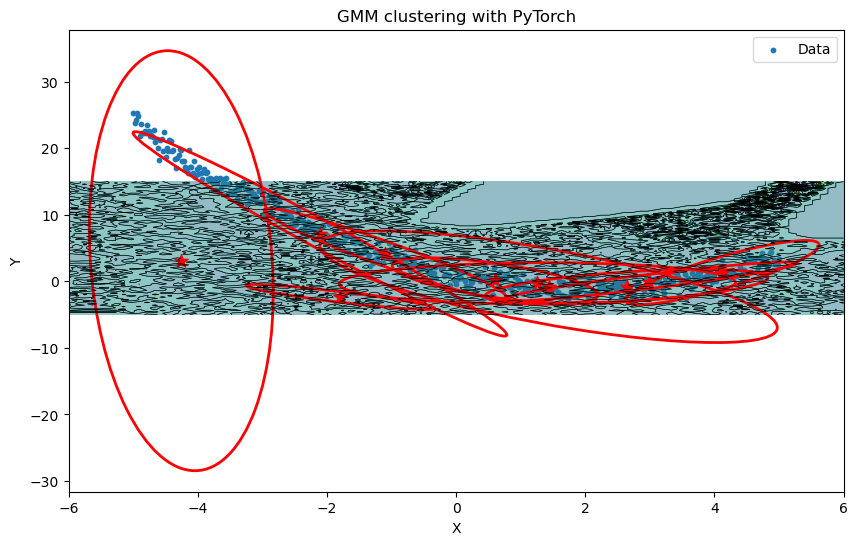

In [3]:
# 데이터 생성
np.random.seed(0)
X = np.linspace(-5, 5, 500)
Y = 0.5 * X**2 - 2 * X + 1 + np.random.normal(0, 1, 500)
data = np.vstack([X, Y]).T
data_tensor = torch.from_numpy(data).float().cuda()

# 모델 초기화 및 학습
n_components = 10
n_features = 2
gmm = PyTorchGMM(n_components=n_components, n_features=n_features, device='cuda')
optimizer = torch.optim.Adam(gmm.parameters(), lr=0.01)

for epoch in range(500):
    optimizer.zero_grad()
    loss = gmm(data_tensor)
    loss.backward()
    optimizer.step()
    
    # pi의 합이 1이 되도록 정규화
    with torch.no_grad():
        gmm.pi.data = gmm.pi.data / torch.sum(gmm.pi.data)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], s=10, label='Data')

# GMM 결과 시각화
x = np.linspace(-6, 6, 100)
y = np.linspace(-5, 15, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
XX_tensor = torch.from_numpy(XX).float().cuda()

Z = gmm.predict_proba(XX_tensor)
Z = Z.sum(axis=1).detach().cpu().numpy().reshape(X.shape)

plt.contour(X, Y, Z, levels=10, linewidths=0.5, colors='k')
plt.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)

# 각 가우시안의 평균과 공분산을 시각화
mus = gmm.mu.detach().cpu().numpy()
covs = gmm._get_cov().detach().cpu().numpy()

for i in range(n_components):
    plt.scatter(mus[i, 0], mus[i, 1], c='red', s=100, marker='*')
    
    # 공분산 타원 그리기
    eigenvalues, eigenvectors = np.linalg.eigh(covs[i])
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues) # 95% 신뢰구간
    ell = plt.matplotlib.patches.Ellipse(xy=mus[i], width=width, height=height, angle=angle,
                                         edgecolor='red', fc='None', lw=2)
    plt.gca().add_patch(ell)


plt.title('GMM clustering with PyTorch')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## 1. 실험 조건 설정

In [ ]:
N_RUNS = 30
NOISE_LEVELS = [0.1, 1, 5, 10, 20, 50]
N_COMPONENTS_RANGE = range(1, 26)
N_SAMPLES = 1000

## 2. 데이터 생성 및 BIC 계산 함수 정의

In [ ]:
def generate_2d_data(n_samples, noise_level):
    x = np.linspace(-10, 10, n_samples)
    y = 0.1 * x**2 - 0.5 * x + 2
    y_noisy = y + np.random.randn(n_samples) * noise_level
    # cuML은 float32 타입을 선호
    return np.vstack([x, y_noisy]).T.astype(np.float32)

def calculate_bic(gmm, data):
    """cuML GMM 모델에 대한 BIC 점수를 수동으로 계산합니다."""
    n_samples, n_features = data.shape
    n_components = gmm.n_components
    
    # 파라미터 개수 계산
    cov_params = n_components * n_features * (n_features + 1) / 2.
    mean_params = n_components * n_features
    weight_params = n_components - 1
    n_params = cov_params + mean_params + weight_params
    
    # BIC 계산
    log_likelihood = gmm.score(data)
    bic = n_params * np.log(n_samples) - 2 * log_likelihood * n_samples
    return bic

## 3. 핵심 연구 로직 실행 (GPU 가속)

In [ ]:
results = []

for noise in tqdm(NOISE_LEVELS, desc="Noise Levels"):
    optimal_k_for_runs = []
    for run in tqdm(range(N_RUNS), desc=f"Runs for Noise {noise}", leave=False):
        data = generate_2d_data(N_SAMPLES, noise)
        
        bics = []
        for k in N_COMPONENTS_RANGE:
            gmm = GaussianMixture(n_components=k, reg_covar=1e-6)
            gmm.fit(data)
            bic_score = calculate_bic(gmm, data)
            bics.append(bic_score)
            
        best_k = N_COMPONENTS_RANGE[np.argmin(bics)]
        optimal_k_for_runs.append(best_k)
        
    results.append({
        'noise_level': noise,
        'mean_k_opt': np.mean(optimal_k_for_runs),
        'std_k_opt': np.std(optimal_k_for_runs)
    })

results_df_2d = pd.DataFrame(results)

## 4. 결과 분석 및 시각화

In [ ]:
print("--- 2차 함수 실험 결과 (GPU) ---")
print(results_df_2d[['noise_level', 'mean_k_opt', 'std_k_opt']])

plt.figure(figsize=(12, 7))
plt.errorbar(
    results_df_2d['noise_level'], 
    results_df_2d['mean_k_opt'], 
    yerr=results_df_2d['std_k_opt'],
    fmt='-o', capsize=5, label='평균 최적 k (오차막대: 1-std)'
)
plt.title('노이즈 수준에 따른 GMM 최적 컴포넌트 개수 변화 (2차 함수, GPU)', fontsize=16)
plt.xlabel('노이즈 수준 (Noise Level)', fontsize=12)
plt.ylabel(f'최적 컴포넌트 개수 (평균, N={N_RUNS}회 실행)', fontsize=12)
plt.xticks(NOISE_LEVELS)
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()